# Vectores Autoregresivos 
# Series de Tiempo de Varias Variables

#### Por Carlos Santillán

#### Febrero 2020


## Resumen

La **Autoregresión de Vectores (VAR)** es un algoritmo de forecasting que puede usarse cuando 2 o más series de tiempo influyen las unas en las otras. Es decir, la relación existente entre las series es bi-direccional. 

## 1. Introducción

Los requerimientos básicos para usar **VAR** son:

1. Necesitamos al menos 2 series de tiempo (variables)

2. Las series de tiempo deben influir una en la otra

**¿Por qué se llaman Autoregresivas?**

Porque cada variable se modela como una función de sus valores anteriores, es decir, los predictores son los lags (valores diferidos en el tiempo) de la misma serie.

**¿Cuál es la diferencia con los modelos AR, ARMA y ARIMA?**

La principal diferencia es que los modelos AR, ARMA y ARIMA son unidireccionales, donde los predictores influyen en $Y$ pero no al revés. En **VAR** las variables influyen entre ellas (bi-direccional).

## 2. Intuición detrás del Modelo VAR

Sabemos que un **Modelo AR($p$)** está dado por:

$$Y_{y} = \alpha + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + ... + \beta_{p}Y_{t-p} + \epsilon_{t}$$

El orden $p$ quiere decir que se usan a lo más $p$ lags como predictores.

En el modelo **VAR**, cada viarble es modelada como **combinación lineal de valores pasados y valores pasados de otras series**. Como tenemos múltiples series de tiempo que influyen entre ellas, el modelo es en realidad un sistema de ecuaciones con una ecuación por serie de tiempo (variable).

I.e. si se tienen 5 series de tiempo en el modelo, entonces tendremos un sistema de 5 ecuaciones.

Por ejemplo: pensemos que tenemos dos series de tiempo (2 variables) conocidas como $Y_{1}$ y $Y_{2}$, necesitamos pronosticar el valor de estas series en el tiempo $t$.

Para calcular $Y_{1}$, el modelo **VAR** usará los valores pasados tanto de $Y_{1}$ como de $Y_{2}$. Del mismo modo se hará el cálculo para $Y_{2}$.

De modo que el sistema de ecuaciones para un modelo **VAR(1)** de dos series de tiempo ($Y_{1}$ y $Y_{2}$) será:

$$Y_{1,t} = \alpha_{1} + \beta_{11, 1}Y_{1,t-1} + \beta_{12, 1}Y_{2, t-1} + \epsilon_{1, t}$$

$$Y_{2,t} = \alpha_{2} + \beta_{21, 1}Y_{1,t-1} + \beta_{22, 1}Y_{2, t-1} + \epsilon_{2, t}$$


Decimos que el modelo anterior es un **VAR(1)** porque cada ecuación es de orden 1, es decir, cada ecuación contiene a lo más 1 lag de cada uno de los predictores ($Y_{1}$ y $Y_{2}$)

De modo que un modelo de 2o orden **VAR(2)** para variables $Y_{1}$ y $Y_{2}$ se vería:

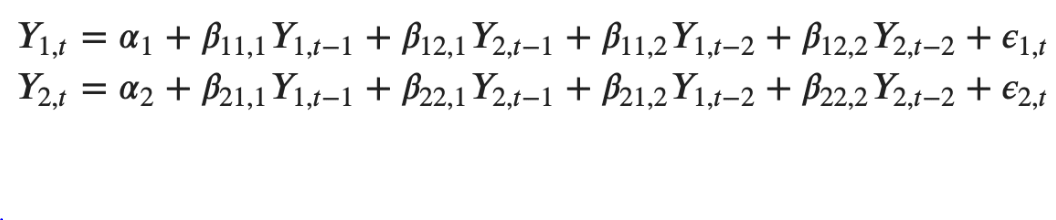

Y si este mismo modelo **VAR(2)** tuviera 3 variables ($Y_{i}, i = 1,2,3$), se vería: 

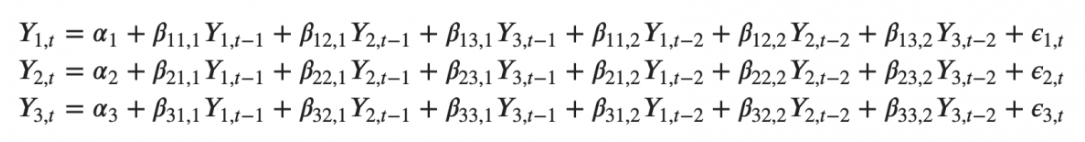

Observamos entonces que mientras incrementamos el número de series de tiempo (variables) en el modelo, el sistema de ecuaciones se vuelve más grande y por ende computacionalmente un poco más complejo.

## 3. Construyendo el Modelo VAR en Python

El procedimiento para construir un modelo **VAR** consta de los siguientes pasos:

1. Analizar características de las series de tiempo

2. Pruebas de causalidad entre las series de tiempo

3. Pruebas de estacionariedad

4. De ser necesario, transformar las series en series estacionarias

5. Encontrar el orden óptimo ($p$)

6. Preparar conjuntos de entrenamiento y prueba

7. Entrenar el modelo

8. Revertir las transformaciones en caso de haberlas hecho

9. Evaluar el modelo con las pruebas pertinentes

10. Hacer forecast

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Importamos Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

## 4. Importamos datos

Para este ejemplo usaremos datos sobre el crecimiento salarial y la inflación. Este Data Set contiene 8 series de tiempo (trimestrales):

1. rgnp: salario real

2. pgnp: salario potencial

3. ulc: costo laboral unitario

4. gdfco: deflactor personal

5. gdf: ponderación del deflactor

6. gdfim: ponderacion fija del deflactor

7. gdfcf: ponderación fija del deflactore persona

8. gdfce: ponderación fija del deflactor de energía

Importamos entonces los datos:

In [3]:
filepath = 'C:/Users/SANTICA4/OneDrive - Novartis Pharma AG/Desktop/BD_L/Data/ejemplo1.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-01-07,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-01-10,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-01-04,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-01-07,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


## 5. Visualizamos Series de Tiempo

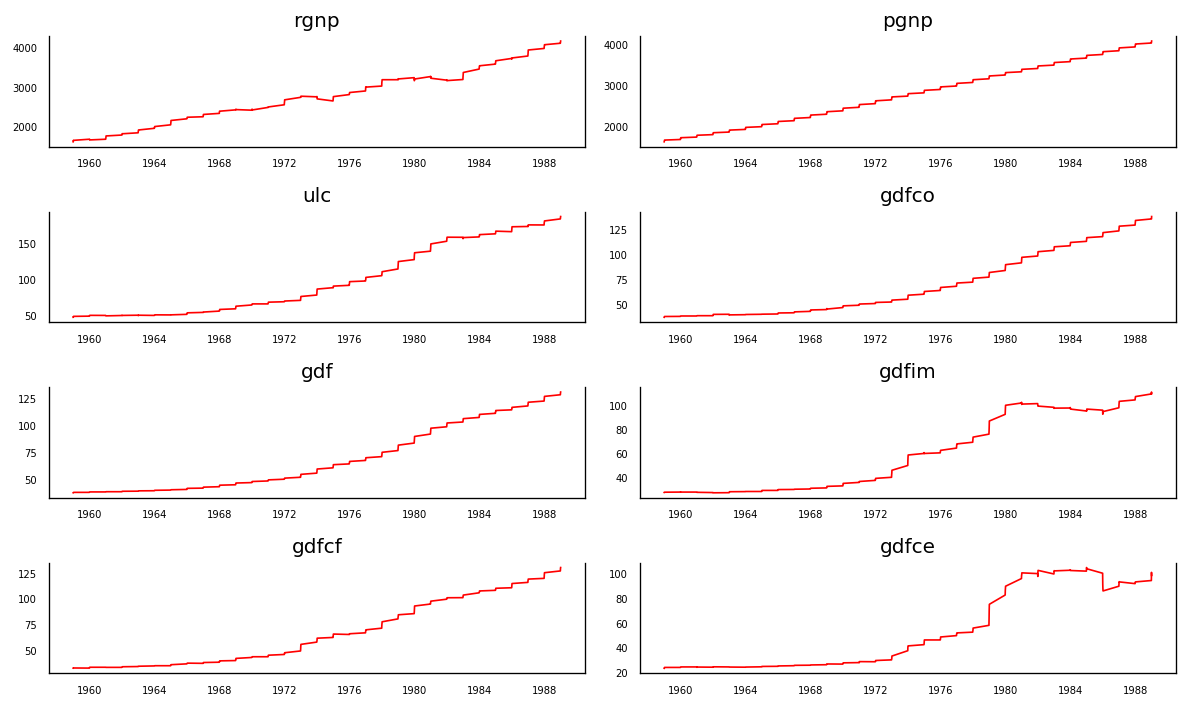

In [4]:
### Gráfica
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    
    ### Decoramos
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Cada una de estas series tiene patrones muy parecidos a lo largo del tiempo excepto por *gdfce* y *gdfim*, donde se comienza a notar un patrón cambiante que inicia en 1980.

El siguiente paso es verificar la causalidad entre nuestras series de tiempo. Lo haremos mediante la **Prueba de Causalidad de Granger** y la **Prueba de Cointegración**

## 6. Pruebas de Causalidad

La idea del **VAR** es que las series influyen unas en otras. Gracias a la Prueba de Causalidad de Granger podemos saber si existe una relación incluso antes de construir el modelo.



¿Cómo funciona la Prueba de Causalidad de Granger?

Se prueba la hipótesis nula de que los coeficientes de los valores anteriores en la ecuación de regresión son 0.

En términos más simples, los valores pasados de una serie $X$ no influyen en los de una serie $Y$. De modo que si el *p-value* de la prueba es **menor que el nivel de significancia** (0.05) entonces podemos rechazar $H_{0}$.



El siguiente código implementa la Prueba de Causalidad de Granger para todas las posibles combinaciones de series en un DataFrame y guarda los *p-values* de cada combinación en una matriz:

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Causalidad de Granger para todas las combinaciones.
    Los renglones son las variables de respuesta, las columnas son predictores. Los valores en la tabla son p-values.
    P-Values menores al nivel de significancia (0.05), implican 
    la hipótesis nula que los coeficientes de los valores pasados son 0 
    , i.e.  X no causa Y puede ser rechazada.

    data      : pandas dataframe con series de tiempo
    variables : lista con nombres de las series.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


En el output resultante, los renglones son las variables de respuesta $Y$ y las columnas son los predictores $X$.

Por ejemplo, si tomamos el valor de 0.0003 (renglón 1, columna 2) se refiere al *p-value* de *pgnp_x* causando *rgnp_y*. Mientras que el 0.000 (renglón 2, columna 1) se refiere al *p-value* de *rgnp_y* causando *pgnp_x*.

¿Cómo interpretar los *p-values*?

Si un *p-value* < 0.05 entonces la serie $X$ correspondiente (columna) causa la variable $Y$ (renglón).

Si observamos la tabla anterior, podemos ver que todas las seriess son causantes entre sí de otras. 

Esto ocasiona que nuestro sistema de series de tiempo multiples es un buen sistema para usar **VAR** con fines de pronosticar.

Después debemos hacer la Prueba de Cointegración.

## 7. Prueba de Cointegración

La cointegración nos dice si existe una conexión estadísticamente significante entre 2 o más series.


¿Qué quiere decir Cointegración?

Primero debemos entender qué es el *orden de integración ($d$)*. Esto no es otra cosa que el número de diferencias requeridas para que una serie no-estacionaria sea estacionaria.

Cuando se tienen 2 o más series y existe una combinación lineal de ellas que tenga un orden de integración $d$ menor que el de la serie individual, entonces la colección de series está cointegrada.

Cuando 2 o más series están cointegradas, esto quiere decir que tienen una relación estadísticamente significativa en el largo plazo.

Esta es la premisa básica del **VAR**, de modo que es una excelente práctica implementar la prueba de cointegración antes de construir el modelo **VAR**.

A continuación implementaremos la prueba usando la librería de *statsmodels*:

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Prueba de Cointegración de Johanson's y Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    ### Resumen
    print('Name   ::  Stat de Prueba > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Stat de Prueba > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


## 8. Datos de Entrenamiento y Prueba

El modelo **VAR** será ajustado en nuestra data de entrenamiento y usada para pronosticar las siguientes 4 observaciones. Estos forecasts serán comparados contra los valores reales en la data de prueba.

Para comparar, usaremos múltiples métricas de precisión.

In [7]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

### Checamos tamaño
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


## 9. Estacionariedad

El modelo **VAR** requiere que las series sean estacionarias. Esto quiere decir que en las series, estadísticas como la media y la varianza no deben depender del tiempo.

Si la serie es no estacionaria, entonces necesitaremos diferenciarla hasta que logremos hacerla estacionaria.

Al diferenciar una serie se reduce su tamaño en 1, y como todas las series deben tener el mismo tamaño, entonces habrá que diferenciar todas las series en el sistema.

Implementemos entonces el ADF Test, primero construiremos la función *adfuller_test()* que escribirá los resultados del ADF Test para cualquier serie dada y la implementará una a una.


In [8]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """ ADFuller para probar estacionariedad de una serie dada e imprime un reporte"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    ### Resumen
    print(f'    Augmented Dickey-Fuller Test en "{name}"', "\n   ", '-'*47)
    print(f' Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.')
    print(f' Nivel de Significancia    = {signif}')
    print(f' Estadística de Prueba        = {output["test_statistic"]}')
    print(f' No. de Lags        = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Valor crítico {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rechazando Hipótesis Nula.")
        print(f" => Serie estacionaria.")
    else:
        print(f" => P-Value = {p_value}. Evidencia débil para rechazar la Hipótesis Nula.")
        print(f" => Serie es no-estacionaria.")   

Ahora llamaremos nuestra función *adfuller_test()* en cada una de nuestras series:

In [9]:
### ADF Test en cada columna
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test en "rgnp" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 Nivel de Significancia    = 0.05
 Estadística de Prueba        = 0.5428
 No. de Lags        = 2
 Valor crítico 1%     = -3.488
 Valor crítico 5%     = -2.887
 Valor crítico 10%    = -2.58
 => P-Value = 0.9861. Evidencia débil para rechazar la Hipótesis Nula.
 => Serie es no-estacionaria.


    Augmented Dickey-Fuller Test en "pgnp" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 Nivel de Significancia    = 0.05
 Estadística de Prueba        = 1.1556
 No. de Lags        = 1
 Valor crítico 1%     = -3.488
 Valor crítico 5%     = -2.887
 Valor crítico 10%    = -2.58
 => P-Value = 0.9957. Evidencia débil para rechazar la Hipótesis Nula.
 => Serie es no-estacionaria.


    Augmented Dickey-Fuller Test en "ulc" 
    -----------------------------------------------
 Hipó

En este caso, el ADF Test confirma que ninguna de nuestras series es estacionaria. Las diferenciaremos todas una vez y de nuevo haremos la prueba:

In [10]:
### 1a Diferencia
df_differenced = df_train.diff().dropna()

Volvemos a correr el ADF Test en cada una de las series:

In [11]:
### ADF Test en cada columna de 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test en "rgnp" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 Nivel de Significancia    = 0.05
 Estadística de Prueba        = -5.3448
 No. de Lags        = 1
 Valor crítico 1%     = -3.488
 Valor crítico 5%     = -2.887
 Valor crítico 10%    = -2.58
 => P-Value = 0.0. Rechazando Hipótesis Nula.
 => Serie estacionaria.


    Augmented Dickey-Fuller Test en "pgnp" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 Nivel de Significancia    = 0.05
 Estadística de Prueba        = -1.8282
 No. de Lags        = 0
 Valor crítico 1%     = -3.488
 Valor crítico 5%     = -2.887
 Valor crítico 10%    = -2.58
 => P-Value = 0.3666. Evidencia débil para rechazar la Hipótesis Nula.
 => Serie es no-estacionaria.


    Augmented Dickey-Fuller Test en "ulc" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz

Después de las primeras diferencias, los salarios reales siguen sin ser estacionarios. Su valor crítico se encuentra entre 5% y 10% del nivel de significancia.

Todas nuestras series deben tener el mismo número de observaciones.

Entonces tenemos 2 opciones:

Nos quedamos con la 1a diferencia o diferenciamos todas las series una vez más:


In [12]:
### Segunda Diferencia
df_differenced = df_differenced.diff().dropna()

Volvemos a correr el ADF Test en las series de la segunda diferencia:

In [13]:
### ADF Test en cada columna del DataFrame de la 2nda Diferencia 
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test en "rgnp" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 Nivel de Significancia    = 0.05
 Estadística de Prueba        = -9.0123
 No. de Lags        = 2
 Valor crítico 1%     = -3.489
 Valor crítico 5%     = -2.887
 Valor crítico 10%    = -2.58
 => P-Value = 0.0. Rechazando Hipótesis Nula.
 => Serie estacionaria.


    Augmented Dickey-Fuller Test en "pgnp" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 Nivel de Significancia    = 0.05
 Estadística de Prueba        = -10.9813
 No. de Lags        = 0
 Valor crítico 1%     = -3.488
 Valor crítico 5%     = -2.887
 Valor crítico 10%    = -2.58
 => P-Value = 0.0. Rechazando Hipótesis Nula.
 => Serie estacionaria.


    Augmented Dickey-Fuller Test en "ulc" 
    -----------------------------------------------
 Hipótesis Nula: Datos tienen raíz unitaria. No-estacionaria.
 N

Todas las series son ahora estacionarias.

Preparemos los datasets de entrenamiento y prueba.

## 10. Encontrando el Orden (P) del modelo VAR

Para seleccionar el orden correcto del modelo VAR, ajustaremos iterativamente órdenes crecientes y escogeremos el que nos de el **menor AIC**.

La práctica usual es observar el AIC, pero también ser puede revisar otros estimadores como el BIC, FPE y HQIC:

In [15]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Orden del Lag =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Orden del Lag = 1
AIC :  -1.367940231545069
BIC :  0.3411847146588811
FPE :  0.25526825173471906
HQIC:  -0.6741331335699581 

Orden del Lag = 2
AIC :  -1.6212373944478244
BIC :  1.6249432095295844
FPE :  0.20113494371371382
HQIC:  -0.30362888267959276 

Orden del Lag = 3
AIC :  -1.76580083870128
BIC :  3.0345473163767824
FPE :  0.18125103746164348
HQIC:  0.18239143783963208 

Orden del Lag = 4
AIC :  -2.000735164470317
BIC :  4.371215137654088
FPE :  0.1555696652148111
HQIC:  0.5849359332771078 

Orden del Lag = 5
AIC :  -1.961953560836399
BIC :  5.999364562242092
FPE :  0.1869279438911482
HQIC:  1.2682063311783294 

Orden del Lag = 6
AIC :  -2.330338652482907
BIC :  7.238452689088579
FPE :  0.16380374017443636
HQIC:  1.5514371669548055 

Orden del Lag = 7
AIC :  -2.5923313523471236
BIC :  8.6023872549378
FPE :  0.1823868583715424
HQIC:  1.9483069621146605 

Orden del Lag = 8
AIC :  -3.317261976458207
BIC :  9.522195810323028
FPE :  0.1557316324820906
HQIC:  1.8896071386220967 

Orden 

C:\Users\SANTICA4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


En el output anterior, el menor AIC se alcanza en el lag 4. Después incrementa en el lag 5 y luego sigue disminuyendo.

Nos quedamos entonces con el modelo del lag 4.

Un método alterno para seleccionar el orden ($p$) del modelo VAR es usar el método *model.select_order(maxlags)*

El orden ($p$) seleccionado es el orden que nos da el menor AIC, BIC, FPE y HQIC:

In [16]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


En este método, los resultados no son del todo congruentes con lo encontrado antes, de modo que como el AIC explícitamente calculado fue menor en lag 4, nos quedaremos con ese resultado.

## 11. Entrenando el Modelo VAR de Orden ($p$)

In [17]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 31, Mar, 2020
Time:                     16:53:20
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

## 12. Buscando Residuales de Correlación (Errores) usando el Estadístico Durbin-Watson

La correlación serial de residuales es usada para revisar si hay algún patrón en los residuales (errores).

¿Esto qué significa para nosostros?

Si hay cualquier correlación en los residuales, entonces existe algún patrón en la serie de tiempo que aun nos falta explicar en el modelo. En ese caso, lo típico es incrementar el orden del modelo o inducir más predictores en el sistema o bscar un diferente algoritmo para modelar nuestra serie de tiempo.

Entonces, revisar la correlación serial es asegurarnos de que el modelo es bueno para explicar las varianzas y  los patrones en la serie de tiempo.

Una manera común de obtener la correlación serial de los errores es usando el estadístico **Durbin-Watson:**

$$DW = \frac{\Sigma^{T}_{t=2} ((e_{t} - e_{t-1})^{2})}{\Sigma^{T}_{t=1} e^{2}_{t}}$$

El valor de este estadístico puede variar entre $0$ y $4$. 

- Mientras más cercano sea su valor a $2$, entonces no hay correlación serial significativa.

- Si su valor es cercano a $0$, existe correlación positiva

- Si su valor es cercano a $4$, implica correlación engativa.

In [20]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))    ### adjust(col)

rgnp : 2.09
pgnp : 2.02
ulc : 2.17
gdfco : 2.05
gdf : 2.25
gdfim : 1.99
gdfcf : 2.2
gdfce : 2.17


Podemos observar que dado que todos los valores son cercanos al $2$, la correlación serial no es significativa.

Proseguimos con el Forecast

## 13. Pronosticando el Modelo VAR usando *statsmodels*

Para poder pronosticar, el modelo VAR debe recibir a lo más el orden del lag de número de observaciones de datos pasados.

Esto sucede porque los términos en el modelo VAR son escencialmente los lags de muchas series de tiempo en nuestro dataset, entonces necesitamos ingresar tantos valores como valores pasados indicados por el lag a usarse en el modelo:

In [21]:
#### Obtenemos el orden del lag
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

### Input de data para forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

Hagamos entonces el forecast:

In [22]:
### Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-01-10,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-01-04,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-01-07,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


Los forecasts se han generado pero están en la escala de la data de entrenamiento usada por el modelo. Entonces, para regresarlo a su escala original, necesitamos des-diferenciar los datos tantas veces hayamos diferenciado la data de input.

En este caso son 2 veces.

## 14. Invertir la transformación para obtener el forecast real

Será conveniente construir una función:

In [23]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revierte la transformación para que el forecast esté en la escala correcta."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    
    for col in columns:
        
        ### Quitamos 2a diferencia
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        
        ### Quitamos 1a diferencia
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [25]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-01-10,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-01-04,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-01-07,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


Los forecasts están ahora en la escala correcta. Grafiquemoslos contra los actuales de la data de prueba.

## 15. Graficando Forecast vs. Actuals

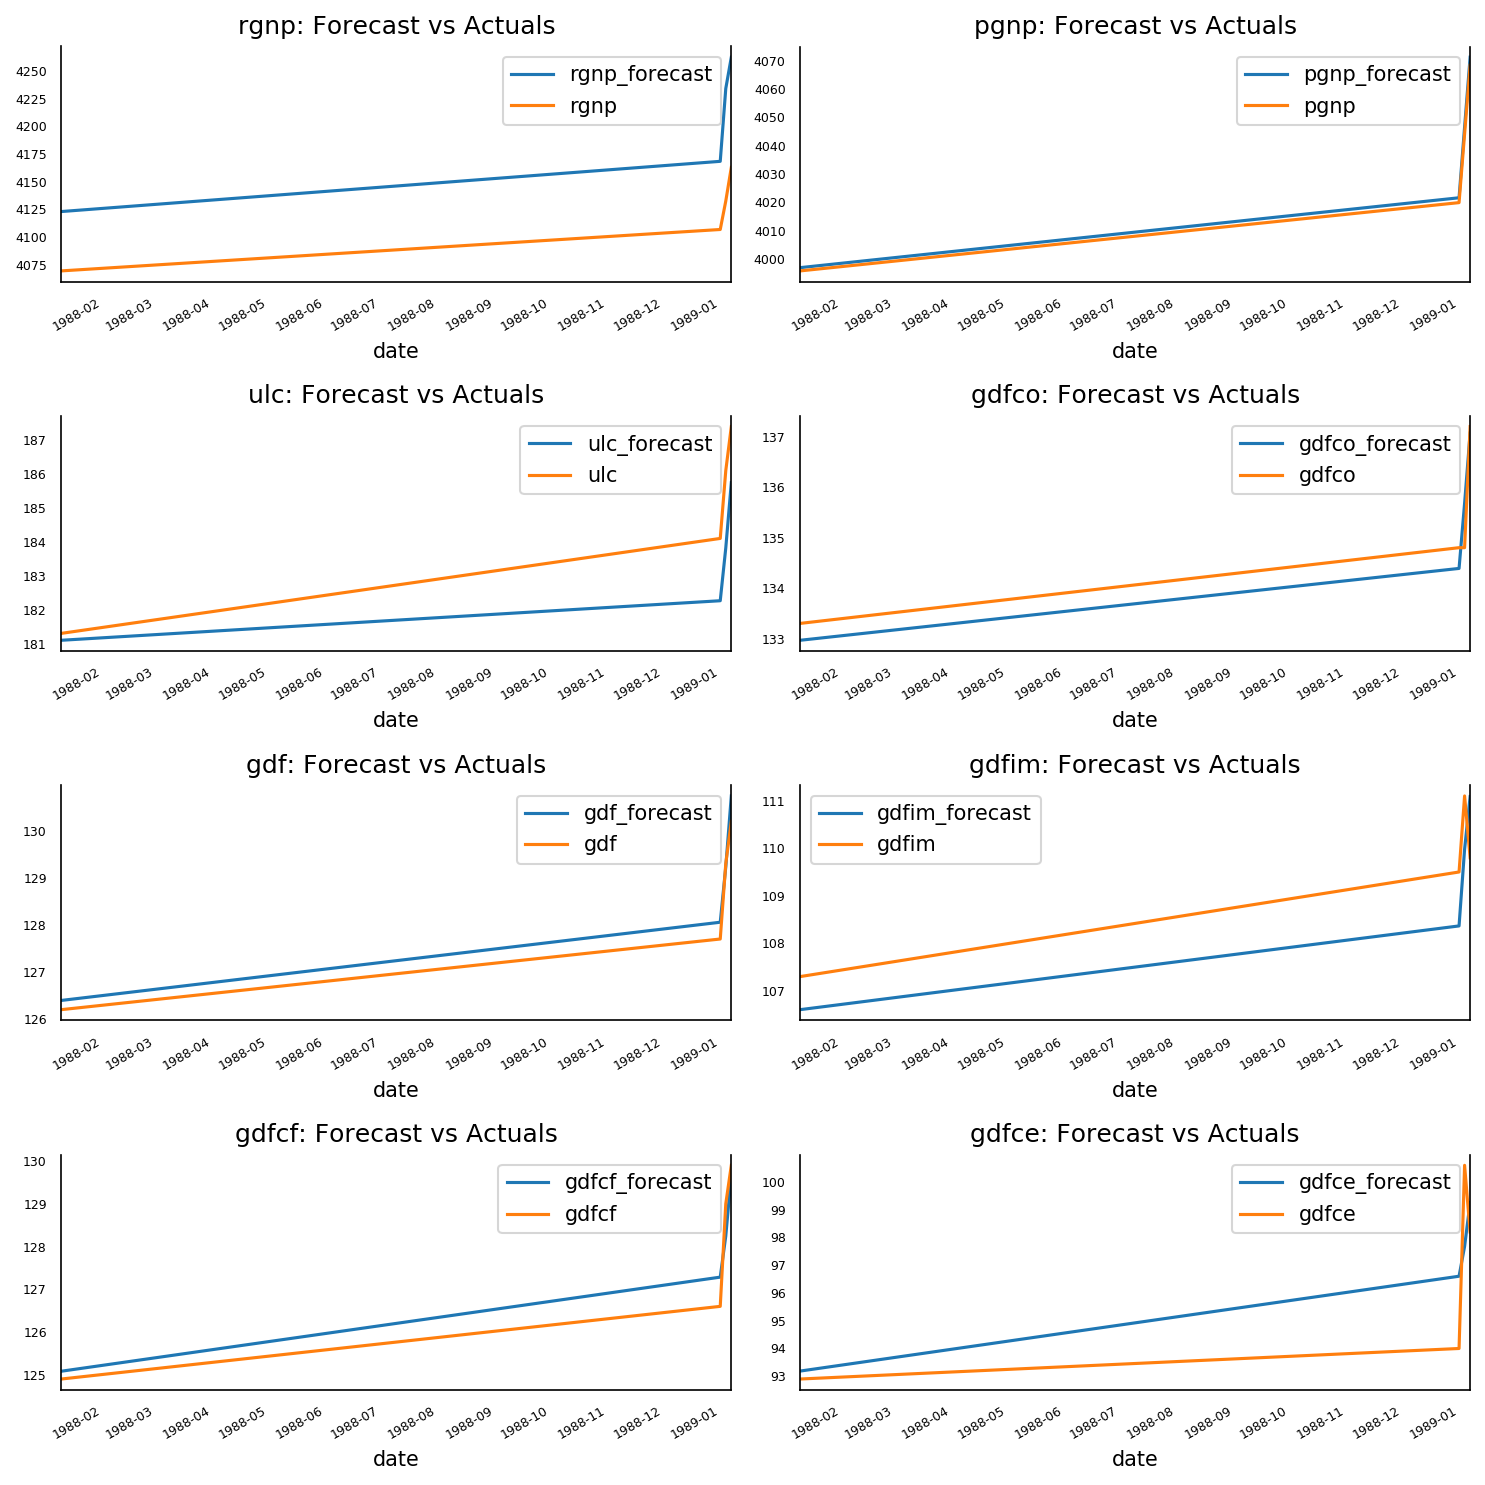

In [26]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## 16. Evaluando Forecasts

Para evaluar los forecasts podemos calcular una serie de métricas, en este caso:

- MAPE
- ME
- MAE
- MPE
- RMSE
- corr
- minmax

In [29]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: rgnp
mape :  0.0192
me :  79.1031
mae :  79.1031
mpe :  0.0192
rmse :  82.0245
corr :  0.9849
minmax :  0.0188

Forecast Accuracy of: pgnp
mape :  0.0005
me :  2.0432
mae :  2.0432
mpe :  0.0005
rmse :  2.146
corr :  1.0
minmax :  0.0005

Forecast Accuracy of: ulc
mape :  0.0081
me :  -1.4947
mae :  1.4947
mpe :  -0.0081
rmse :  1.6856
corr :  0.963
minmax :  0.0081

Forecast Accuracy of: gdfco
mape :  0.0033
me :  0.0007
mae :  0.4384
mpe :  0.0
rmse :  0.5169
corr :  0.9407
minmax :  0.0032

Forecast Accuracy of: gdf
mape :  0.0023
me :  0.2554
mae :  0.29
mpe :  0.002
rmse :  0.3392
corr :  0.9905
minmax :  0.0022

Forecast Accuracy of: gdfim
mape :  0.0097
me :  -0.4166
mae :  1.06
mpe :  -0.0038
rmse :  1.0826
corr :  0.807
minmax :  0.0096

Forecast Accuracy of: gdfcf
mape :  0.0036
me :  -0.0271
mae :  0.4604
mpe :  -0.0002
rmse :  0.5286
corr :  0.9713
minmax :  0.0036

Forecast Accuracy of: gdfce
mape :  0.0177
me :  0.2577
mae :  1.72
mpe :  0.0031
rmse 

## 17. Conclusión

Hemos cubierto el Modelo VAR desde 0, empezando por la intuición detrás del modelo, seguido de:

- interpretando la fórmula, 
- pruebas de causalidad, 
- encontrando el orden óptimo ($p$) del modelo VAR,
- preparar la data para forecasting, 
- construir el modelo, 
- verificando la autocorrelación serial, 
- invirtiendo la transformación para obtener los forecasts actuales y 
- graficamos los resultados para finalmente calcular métricas de precisión.